In [61]:
# dataset - https://www.kaggle.com/datasets/rm1000/lung-cancer-histopathological-images

Loading Dataset

Upload API token

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d rm1000/lung-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/rm1000/lung-cancer-histopathological-images
License(s): CC-BY-SA-4.0
100% 1.55G/1.55G [00:14<00:00, 146MB/s]
100% 1.55G/1.55G [00:14<00:00, 113MB/s]


Extracting zipfile

In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/lung-cancer-histopathological-images.zip','r')  #opens zipfile
zip_ref.extractall('/content')   #extract contents and store in '/content' directory
zip_ref.close()

750 images of lung tissue augumented to 15000 images

5000 benign lung tissue, 5000 lung adenocarcinomas, 5000 lung squamous cell carcinomas

In [5]:
import tensorflow as tf
from tensorflow import keras

Acessing data from directory

method  - use 'os' to acess file


In [6]:
import os
import pandas as pd

In [7]:
os.listdir('/content/lung_cancer')

['benign', 'squamous_cell_carcinoma', 'adenocarcinoma']

In [8]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)  #get folder names , ['lung_aca', 'lung_n', 'lung_scc']

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)   # joins 2 path , (lung_image_sets + lung_aca - lung_image_sets\lung_aca)
        filelist = os.listdir(foldpath)       #make list of images in 'lung_image_sets\lung_aca'
        for file in filelist:
            fpath = os.path.join(foldpath, file)   # lung_image_sets\lung_aca + image1 - lung_image_sets\lung_aca\image1

            filepaths.append(fpath)    #stores image
            labels.append(fold)        #stores label

    # Concatenate data paths(images) with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df

In [9]:
# change label names to its original names
def change_label_names(df, column_name):
    index = {'adenocarcinoma': 'Lung_adenocarcinoma', 'benign': 'Lung_benign_tissue', 'squamous_cell_carcinoma': 'Lung squamous_cell_carcinoma'}
    df[column_name] = df[column_name].replace(index)

In [10]:
data_dir = '/content/lung_cancer'
df = loading_the_data(data_dir)
change_label_names(df, 'labels')

In [11]:
df.head()

,filepaths,labels
0,/content/lung_cancer/benign/3707.jpg,Lung_benign_tissue
1,/content/lung_cancer/benign/4749.jpg,Lung_benign_tissue
2,/content/lung_cancer/benign/1123.jpg,Lung_benign_tissue
3,/content/lung_cancer/benign/2291.jpg,Lung_benign_tissue
4,/content/lung_cancer/benign/3367.jpg,Lung_benign_tissue


Data preprocessing


In [12]:
df['labels'].value_counts() #balanced

,count
labels,
Lung_benign_tissue,5000
Lung squamous_cell_carcinoma,5000
Lung_adenocarcinoma,5000


split data


In [13]:
from sklearn.model_selection import train_test_split
train_df,ts_df = train_test_split(df,test_size=0.2)
valid_df, test_df = train_test_split(ts_df, test_size = 0.5)

In [14]:
train_df.shape

(12000, 2)

Converting data into numpy arrays

In [15]:
import tensorflow
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator   #data augumentation

In [16]:
tr_gen = ImageDataGenerator(rescale=1./255)   #scales data
train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'filepaths', y_col= 'labels', target_size= (224,224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= 32)   #creates new image

ts_gen = ImageDataGenerator(rescale=1./255)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col= 'filepaths', y_col= 'labels', target_size= (224,224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= 32)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col= 'filepaths', y_col= 'labels', target_size= (224,224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= 32)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


In [17]:
test_gen

In [18]:
len(train_gen)   # for 1 batch

375

Visualizing data

0 - Lung squamous_cell_carcinoma

1 - Lung_adenocarcinoma

2 - Lung_benign_tissue

In [19]:
images, labels = next(train_gen)      # get a batch size samples from the generator
classes = list(train_gen.class_indices.keys())  #access class names

In [20]:
print(labels[4])
print(classes[np.argmax(labels[4])])

[0. 1. 0.]
Lung_adenocarcinoma


Text(0.5, 1.0, 'Lung squamous_cell_carcinoma')

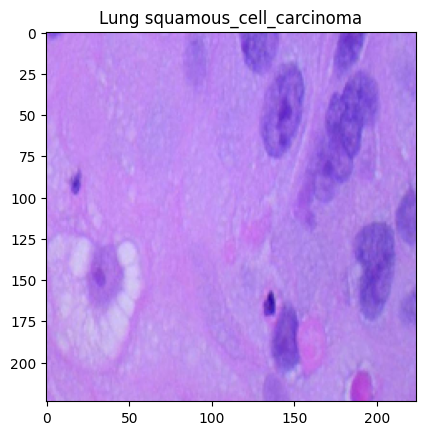

In [23]:
import matplotlib.pyplot as plt
i = 10
plt.imshow(images[i])
plt.title(classes[np.argmax(labels[i])])

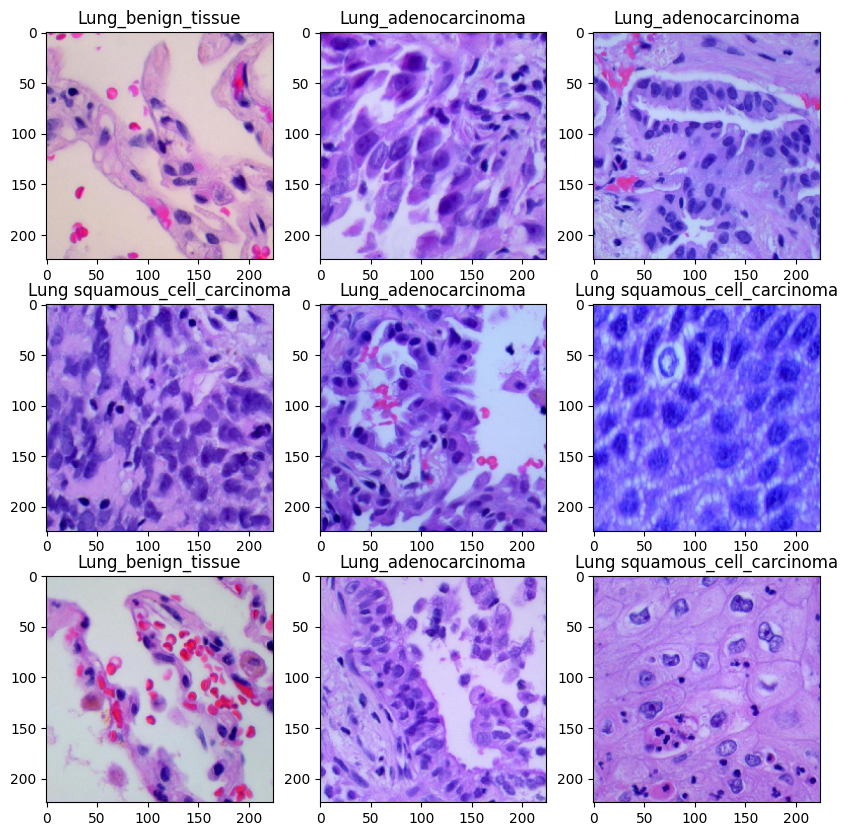

In [24]:
plt.figure(figsize= (10,10))

for i in range(0,9):
  plt.subplot(3,3,i+1)
  plt.imshow(images[i])
  plt.title(classes[np.argmax(labels[i])])


CNN model

fine tuning pretrained model EfficientnetB3

In [25]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,GlobalAveragePooling2D,Flatten,BatchNormalization,Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax

In [26]:
from tensorflow.keras.applications import EfficientNetB3

In [27]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape = (224,224,3), pooling= None)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
#adding custom features on base_model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
predictions = Dense(3, activation='softmax')(x)


In [29]:
#final model
EfficientNetB3_model = Model(inputs = base_model.input, outputs = predictions)

In [30]:
EfficientNetB3_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
EfficientNetB3_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 10,991,282 (41.93 MB)

 Trainable params: 10,900,587 (41.58 MB)

 Non-trainable params: 90,695 (354.28 KB)

In [32]:
callback = EarlyStopping(monitor = 'val_loss',patience=5,min_delta=0.00001,verbose=1)

training model

In [33]:
epochs = 20
EfficientNetB3_history = EfficientNetB3_model.fit(train_gen, epochs= epochs, verbose= 1,callbacks=callback, validation_data= valid_gen, shuffle= False)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 238s 319ms/step - accuracy: 0.5759 - loss: 1.0241 - val_accuracy: 0.3893 - val_loss: 1.3012
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 103s 273ms/step - accuracy: 0.8488 - loss: 0.3937 - val_accuracy: 0.8960 - val_loss: 0.3166
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 272ms/step - accuracy: 0.9115 - loss: 0.2610 - val_accuracy: 0.9433 - val_loss: 0.1738
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 272ms/step - accuracy: 0.9378 - loss: 0.1934 - val_accuracy: 0.9680 - val_loss: 0.0963
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 271ms/step - accuracy: 0.9586 - loss: 0.1409 - val_accuracy: 0.9407 - val_loss: 0.1818
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 103s 273ms/step - accuracy: 0.9688 - loss: 0.1114 - val_accuracy: 0.8640 - val_loss: 0.3586
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 272ms/step - accuracy: 0.9751 - loss: 0.0938 - val_accuracy: 0.9873 - val_loss: 0.0569
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 271ms/step - accuracy: 0.9852 -

Evaluating

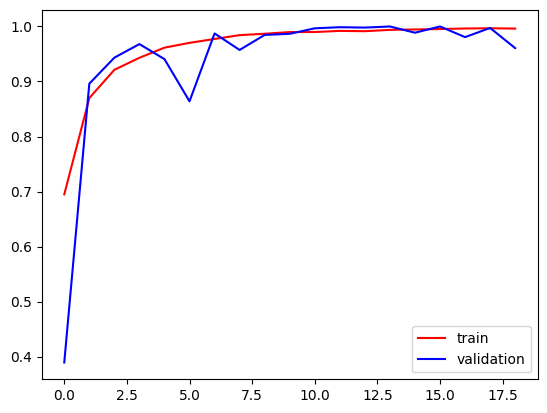

In [34]:
plt.plot(EfficientNetB3_history.history['accuracy'],color='red',label='train')
plt.plot(EfficientNetB3_history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

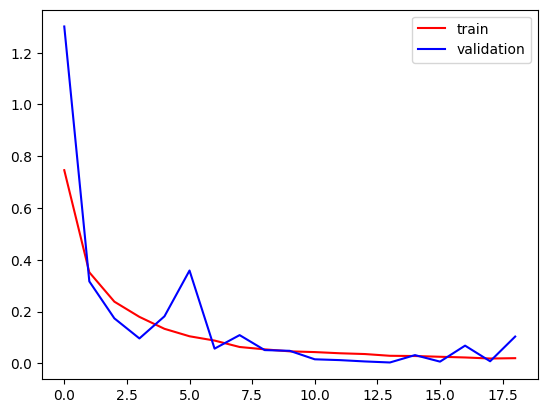

In [35]:
plt.plot(EfficientNetB3_history.history['loss'],color='red',label='train')
plt.plot(EfficientNetB3_history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [36]:
import itertools

In [37]:
from sklearn.metrics import accuracy_score,confusion_matrix

In [38]:
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])


In [39]:
# Model evaluation
model_evaluation(EfficientNetB3_model)

375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - accuracy: 0.9739 - loss: 0.0812
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.9542 - loss: 0.1058
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.9738 - loss: 0.0929
Train Loss:  0.08090580999851227
Train Accuracy:  0.9739999771118164
--------------------
Validation Loss:  0.10354116559028625
Validation Accuracy:  0.9606666564941406
--------------------
Test Loss:  0.09668496996164322
Test Accuracy:  0.9733333587646484


Predicting image

In [44]:
import cv2

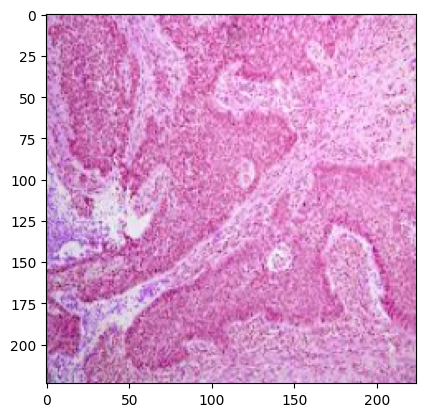

In [58]:
def pre_process(img):
  test_img = cv2.imread(img)
  test_img = test_img/255
  test_img = cv2.resize(test_img,(224,224))
  plt.imshow(test_img)
  plt.show()
  return test_img

img = "/content/squamous.jpg"
test_img = pre_process(img)

In [59]:
test_input = test_img.reshape((1,224,224,3))

0 - Lung squamous_cell_carcinoma

1 - Lung_adenocarcinoma

2 - Lung_benign_tissue

In [60]:
EfficientNetB3_model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


array([[0.9820424 , 0.01103834, 0.00691938]], dtype=float32)